In [278]:
import torch
import torch_geometric
import torch.nn as nn
from e3nn.o3 import FullyConnectedTensorProduct
import numpy as np
import matplotlib.pyplot as plt

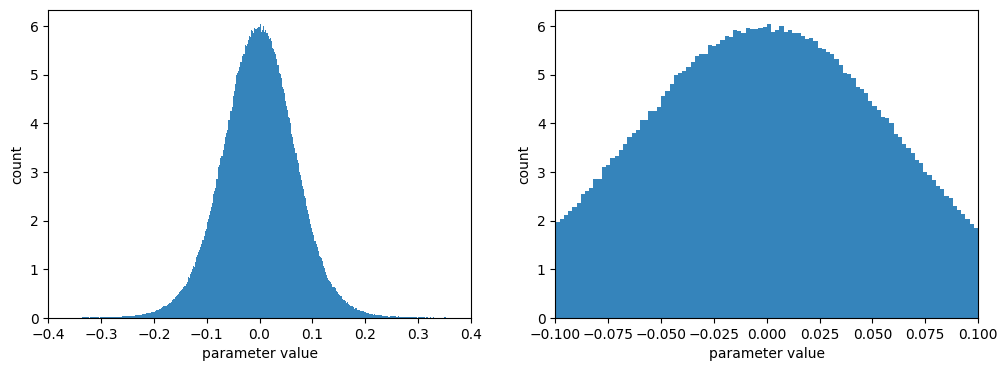

In [489]:
def inspect_distr(seq_num):
    """
    Inspect the distribution of all trained parameters.
    
    ------------
    seq_num: str or int
        the 5-digit sequence string representing a trained model
    """

    # load trained parameters
    trained_paras = torch.load('saved models/segnn_qm9_alpha_' + str(seq_num) + '_cuda:0.pt')
    
    # (!) In case the model is obtained from torch.nn.utils.prune, this ensures modules have the right parameters
    modified_trained_paras = trained_paras.copy()
    for k, v in trained_paras.items():
        if k.endswith(".tp.weight_orig"):
            new_k = k.replace(".tp.weight_orig", ".tp.weight")
            mask_key = k.replace(".tp.weight_orig", ".tp.weight_mask")
            mask = trained_paras[mask_key].detach().cpu()
            zero_mask = torch.nonzero(mask==0)  # return indices of zeros
            v[zero_mask] = 0
            modified_trained_paras[new_k] = v
    trained_paras = modified_trained_paras
    keys_to_remove = [k for k in modified_trained_paras if k.endswith(".tp.weight_orig") or k.endswith(".tp.weight_mask")]
    for k in keys_to_remove:
        del trained_paras[k]

    tensor_collection = []
    for k, v in trained_paras.items():
        if "tp.weight" in k:
            tensor_collection.append(v)

    all_entries = []
    for tensor in tensor_collection:
        all_entries.extend(tensor.flatten().tolist())
    
    bin_width = 0.002
    # add -1 and 1 to collect all values outside (-0.4, 0.4)
    bin_edges = [-1] + list(np.arange(-0.4, 0.4 + bin_width, bin_width)) + [1]

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(all_entries, density=True, bins = bin_edges, alpha=0.9)
    plt.xlim(-0.4, 0.4)
    plt.xlabel("parameter value")
    plt.ylabel("count")

    plt.subplot(1, 2, 2)
    plt.hist(all_entries, density=True, bins = bin_edges, alpha=0.9)
    plt.xlim(-0.1, 0.1)
    plt.xlabel("parameter value")
    plt.ylabel("count")
    
    plt.show()


    
# inspect_distr(33525)  # baseline
# inspect_distr(33351)  # 1e-3
# inspect_distr(18950)  # 5e-3
# inspect_distr(92158)  # 5e-2
# inspect_distr(17293)
# inspect_distr(40217)

# inspect_distr(518680)  # baseline: l_h=3, l_a=4
# inspect_distr(140662)  # L1=5e-2: l_h=3, l_a=4


dict_keys(['embedding_layer.tp.weight', 'layers.0.message_layer_1.tp.weight', 'layers.0.message_layer_2.tp.weight', 'layers.0.update_layer_1.tp.weight', 'layers.0.update_layer_2.tp.weight', 'layers.1.message_layer_1.tp.weight', 'layers.1.message_layer_2.tp.weight', 'layers.1.update_layer_1.tp.weight', 'layers.1.update_layer_2.tp.weight', 'layers.2.message_layer_1.tp.weight', 'layers.2.message_layer_2.tp.weight', 'layers.2.update_layer_1.tp.weight', 'layers.2.update_layer_2.tp.weight', 'layers.3.message_layer_1.tp.weight', 'layers.3.message_layer_2.tp.weight', 'layers.3.update_layer_1.tp.weight', 'layers.3.update_layer_2.tp.weight', 'layers.4.message_layer_1.tp.weight', 'layers.4.message_layer_2.tp.weight', 'layers.4.update_layer_1.tp.weight', 'layers.4.update_layer_2.tp.weight', 'layers.5.message_layer_1.tp.weight', 'layers.5.message_layer_2.tp.weight', 'layers.5.update_layer_1.tp.weight', 'layers.5.update_layer_2.tp.weight', 'layers.6.message_layer_1.tp.weight', 'layers.6.message_laye

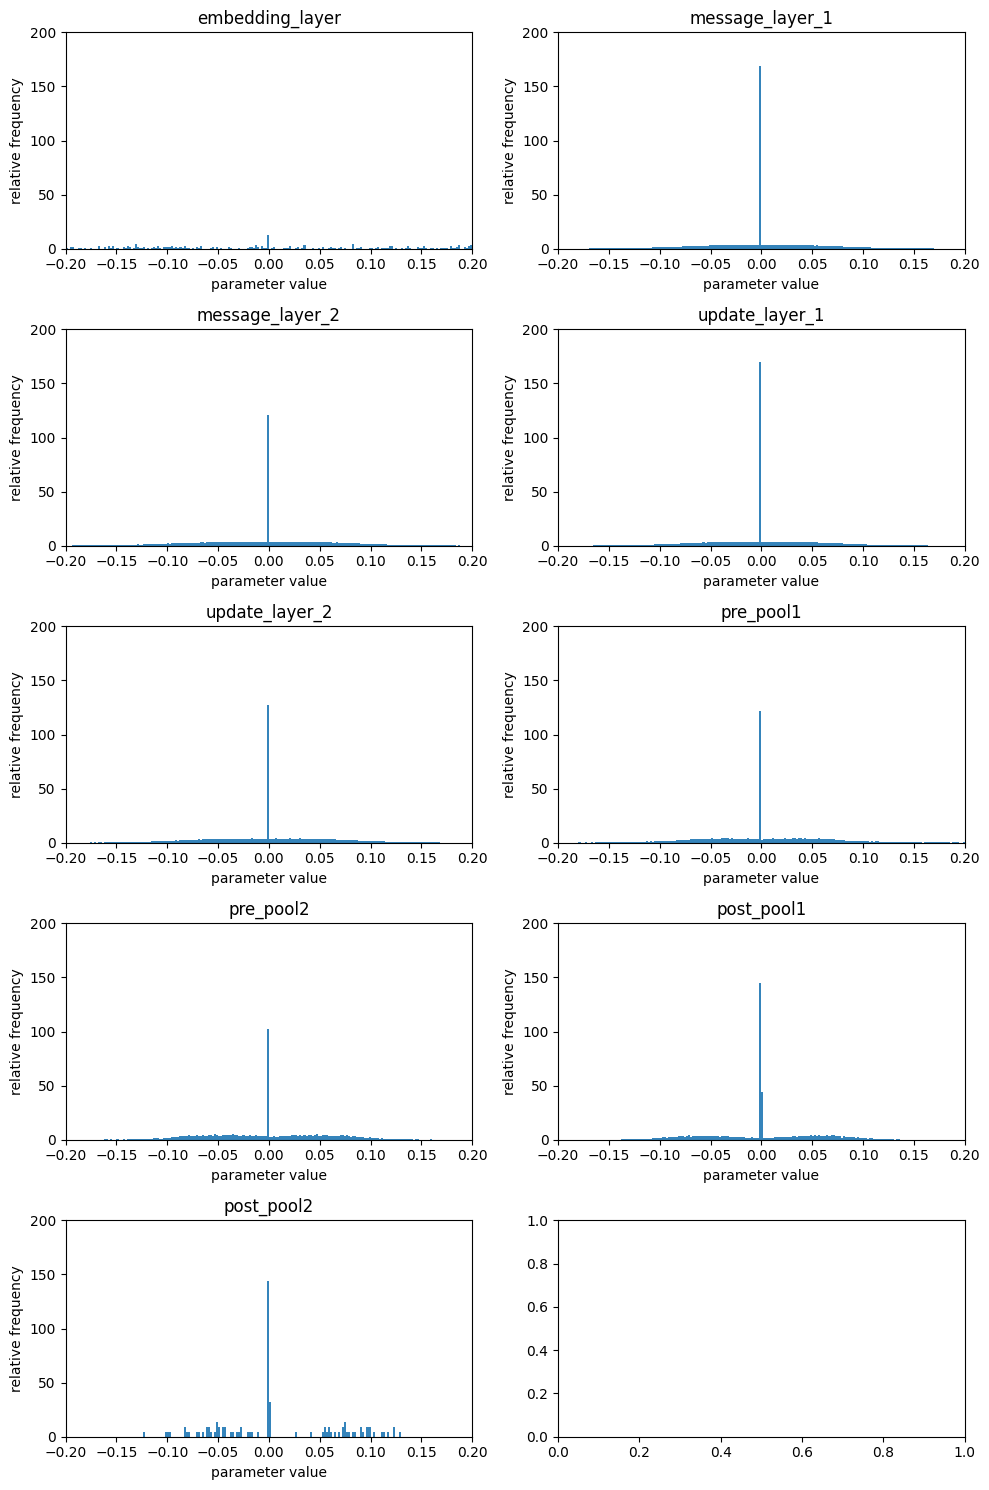

In [421]:
def inspect_layer_distr(seq_num):
    """
    Inspect the distribution of trained parameters within each type of layers separately.
    
    ------------
    seq_num: str or int
        the 6-digit sequence string representing a trained model
    """
    
    # load trained parameters
    trained_paras = torch.load('saved models/segnn_qm9_alpha_' + str(seq_num) + '_cuda:0.pt')
            
    # (!) In case the model is obtained from torch.nn.utils.prune, this ensures modules have the right parameters
    modified_trained_paras = trained_paras.copy()
    for k, v in trained_paras.items():
        if k.endswith(".tp.weight_orig"):
            new_k = k.replace(".tp.weight_orig", ".tp.weight")
            mask_key = k.replace(".tp.weight_orig", ".tp.weight_mask")
            mask = trained_paras[mask_key].detach().cpu()
            zero_mask = torch.nonzero(mask==0)  # return indices of zeros
            v[zero_mask] = 0
            modified_trained_paras[new_k] = v
    trained_paras = modified_trained_paras
    keys_to_remove = [k for k in modified_trained_paras if k.endswith(".tp.weight_orig") or k.endswith(".tp.weight_mask")]
    for k in keys_to_remove:
        del trained_paras[k]
    
    layer_weight_dict = {}
    for k, v in trained_paras.items():
        if "tp.weight" in k:
            layer_weight_dict[k] = v
    
    # check layer names
    print(layer_weight_dict.keys(), end='\n')

    pooled_layer_weight_dict = {'embedding_layer':[], 'message_layer_1':[], 'message_layer_2':[], 
                                'update_layer_1':[], 'update_layer_2':[], 'pre_pool1':[], 'pre_pool2':[],
                                'post_pool1':[], 'post_pool2':[]}
    for k, v in layer_weight_dict.items():
        for name in pooled_layer_weight_dict.keys():
            if name in k:
                pooled_layer_weight_dict[name].extend(v.flatten().tolist())
    
    num_rows = len(pooled_layer_weight_dict) // 2
    if len(pooled_layer_weight_dict) % 2 != 0:
        num_rows += 1
    
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows), tight_layout=True)
    
    bin_width = 0.002
    # add -1 and 1 to collect all values outside (-0.4, 0.4)
    bin_edges = [-1] + list(np.arange(-0.4, 0.4 + bin_width, bin_width)) + [1]
    
    for idx, (key, value) in enumerate(pooled_layer_weight_dict.items()):
        row = idx // 2
        col = idx % 2
        axs[row, col].hist(value, density=True, bins=bin_edges, alpha=0.9)
        axs[row, col].set_xlim(-0.2, 0.2)
        axs[row, col].set_ylim(0, 200)
        axs[row, col].set_xlabel('parameter value')
        axs[row, col].set_ylabel('relative frequency')
        axs[row, col].set_title(key)
        
    plt.show()


# inspect_layer_distr(33525)  # baseline
# inspect_layer_distr(33351)  # 1e-3
# inspect_layer_distr(18950)  # 5e-3
# inspect_layer_distr(92158)  # 5e-2
inspect_layer_distr(965837)

In [355]:
"""A quick example that illustrates the main idea for `inspect_type_distr` below."""
from e3nn.o3 import Irreps

class O3TensorProduct(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.tp = FullyConnectedTensorProduct(
            irreps_in1=Irreps('1x1e + 1x0e'),
            irreps_in2=Irreps('1x1e + 1x0e'),
            irreps_out=Irreps('2x0e + 3x1e'),
            internal_weights = True,
            shared_weights = True
        )
        print(self.tp)

layer1 = O3TensorProduct()
print(list(layer1.named_parameters()))
print('\n')
    
for w in layer1.tp.weight_views(yield_instruction=True):
    print(w[1], w[2], sep='\n')
    print('\n')

print(layer1.tp.irreps_out[w[1][2]].ir.l)

FullyConnectedTensorProduct(1x1e+1x0e x 1x1e+1x0e -> 2x0e+3x1e | 13 paths | 13 weights)
[('tp.weight', Parameter containing:
tensor([-0.2428, -0.3507, -0.4021, -0.2266,  0.0921, -0.7783,  0.9674, -1.8263,
        -0.3117, -0.5236,  1.6545, -0.1289, -0.8144], requires_grad=True))]


Instruction(i_in1=0, i_in2=0, i_out=0, connection_mode='uvw', has_weight=True, path_weight=0.7071067811865476, path_shape=(1, 1, 2))
tensor([[[-0.2428, -0.3507]]], grad_fn=<ViewBackward0>)


Instruction(i_in1=0, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.0, path_shape=(1, 1, 3))
tensor([[[-0.4021, -0.2266,  0.0921]]], grad_fn=<ViewBackward0>)


Instruction(i_in1=0, i_in2=1, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.0, path_shape=(1, 1, 3))
tensor([[[-0.7783,  0.9674, -1.8263]]], grad_fn=<ViewBackward0>)


Instruction(i_in1=1, i_in2=0, i_out=1, connection_mode='uvw', has_weight=True, path_weight=1.0, path_shape=(1, 1, 3))
tensor([[[-0.3117, -0.5236,  1.6545]]]

Determined irrep type: 36x0e+36x1o+36x2e
(0e, 0e, 0e): 0.06760424377004688; total: 145908
(0e, 1o, 1o): 0.1111111111111111; total: 54684
(0e, 2e, 2e): 0.08905712822763515; total: 54684
(1o, 0e, 1o): 0.15382495590828923; total: 54432
(1o, 1o, 0e): 0.11548583553791887; total: 145152
(1o, 1o, 2e): 0.15380658436213993; total: 54432
(1o, 2e, 1o): 0.16128380364491476; total: 54432
(1o, 3o, 2e): 0.1259920634920635; total: 54432
(2e, 0e, 2e): 0.11076205173427396; total: 54432
(2e, 1o, 1o): 0.15512933568489123; total: 54432
(2e, 2e, 0e): 0.08932016093474426; total: 145152
(2e, 2e, 2e): 0.11787184009406232; total: 54432
(2e, 3o, 1o): 0.12604717813051147; total: 54432


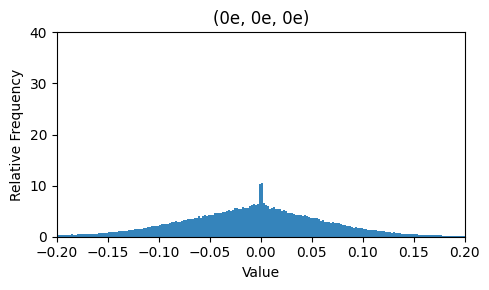

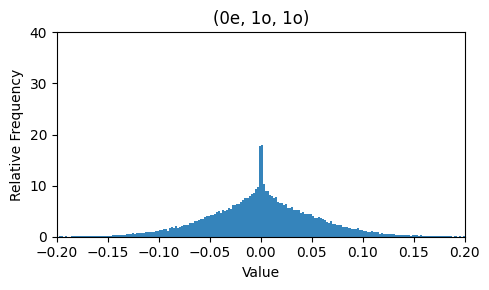

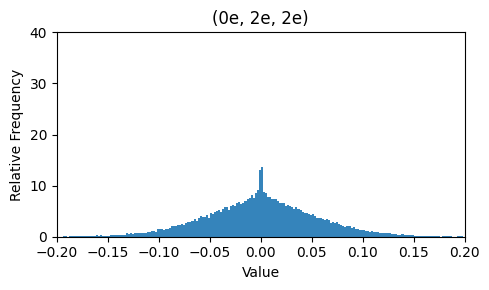

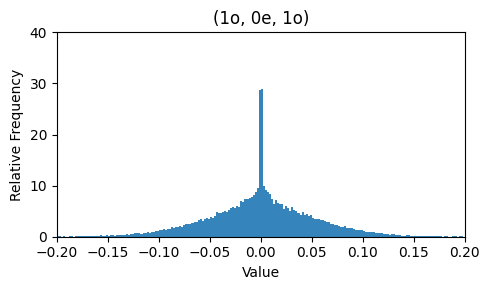

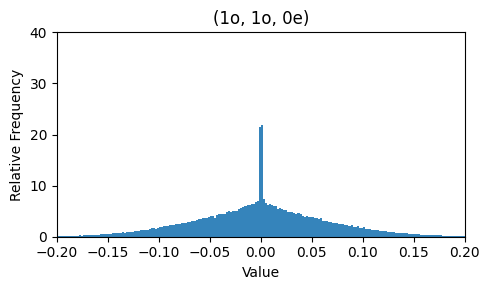

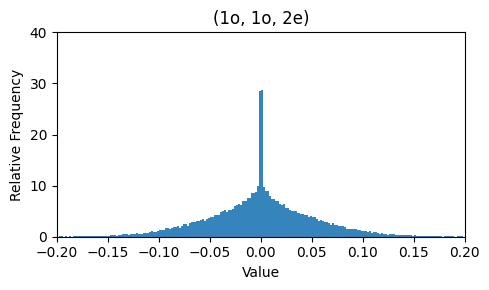

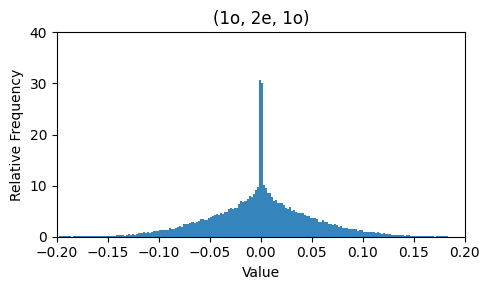

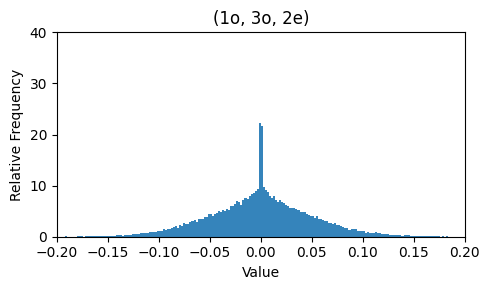

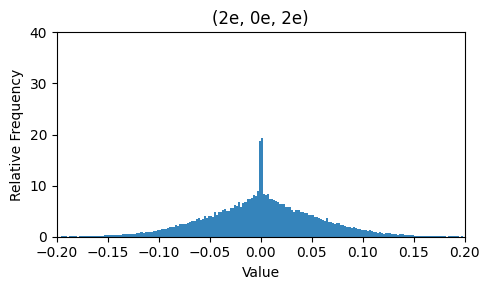

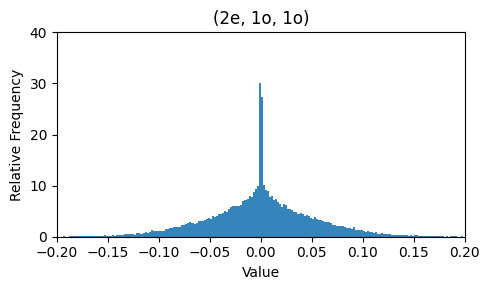

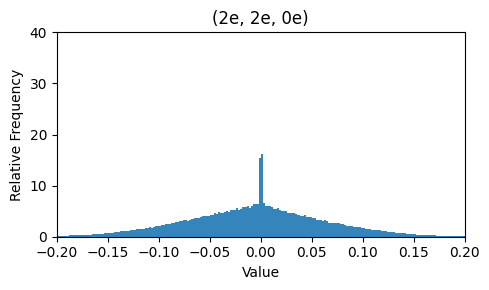

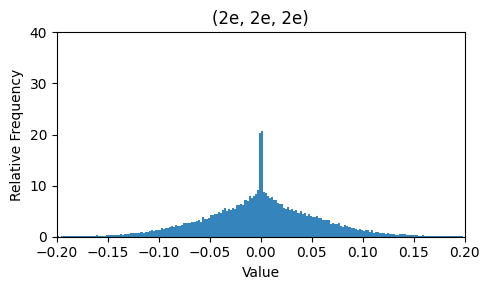

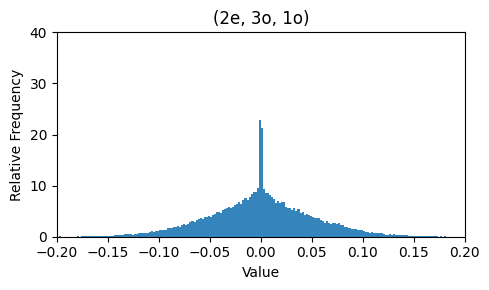

In [501]:
from e3nn.o3 import Irreps
from models.segnn.segnn import SEGNN
from models.balanced_irreps import WeightBalancedIrreps

def inspect_type_distr(seq_num, save_name, lmax_h = 2, lmax_attr = 3, layers = 7):
    """
    Inspect the distribution of trained parameters separately for each distinct (l_in1, l_in2, l_out) tuple.
    
    ------------
    seq_num: str or int
        the 6-digit sequence string representing a trained model
    name: str
        name for the setting
    """
    
    # load trained parameters
    trained_paras = torch.load('saved models/segnn_qm9_alpha_' + str(seq_num) + '_cuda:0.pt')
    
    # check which layers contain tp.weight
    # layer_names = []
    # for k, v in trained_paras.items():
    #     if k.endswith(".tp.weight"):
    #         layer_names.append(k[:-len(".tp.weight")])
    # print(layer_names)

    # recreate parser argument 
    hidden_features = 128
    layers = layers
    norm = "instance"
    pool = "avg"
    task = "graph"
    
    # recreate model input
    input_irreps = Irreps("5x0e")
    output_irreps = Irreps("1x0e")
    edge_attr_irreps = Irreps.spherical_harmonics(lmax_attr)
    node_attr_irreps = Irreps.spherical_harmonics(lmax_attr)
    additional_message_irreps = Irreps("1x0e")
    hidden_irreps = WeightBalancedIrreps(
            Irreps("{}x0e".format(hidden_features)), node_attr_irreps, sh=True, lmax=lmax_h)
    
    # create an empty model of conformable shape
    model = SEGNN(input_irreps,
                  hidden_irreps,
                  output_irreps,
                  edge_attr_irreps,
                  node_attr_irreps,
                  num_layers=layers,
                  norm=norm,
                  pool=pool,
                  task=task,
                  additional_message_irreps=additional_message_irreps)
    
    
    # (!) In case the model is obtained from torch.nn.utils.prune, this ensures modules have the right parameters
    modified_trained_paras = trained_paras.copy()
    for k, v in trained_paras.items():
        if k.endswith(".tp.weight_orig"):
            new_k = k.replace(".tp.weight_orig", ".tp.weight")
            mask_key = k.replace(".tp.weight_orig", ".tp.weight_mask")
            mask = trained_paras[mask_key].detach().cpu()
            zero_mask = torch.nonzero(mask==0)  # return indices of zeros
            v[zero_mask] = 0
            modified_trained_paras[new_k] = v
    trained_paras = modified_trained_paras
    keys_to_remove = [k for k in modified_trained_paras if k.endswith(".tp.weight_orig") or k.endswith(".tp.weight_mask")]
    for k in keys_to_remove:
        del trained_paras[k]
    
    
    # load model using trained parameters
    model.load_state_dict(trained_paras)
    
    # record all the layers that contain tp.weight
    layers = []
    # layers = [model.embedding_layer, model.pre_pool1, model.pre_pool2,
    #           model.post_pool1, model.post_pool2]
    
    for segnn_layer in model.layers:
        layers.append(segnn_layer.message_layer_1)
        layers.append(segnn_layer.message_layer_2)
        layers.append(segnn_layer.update_layer_1)
        layers.append(segnn_layer.update_layer_2)
    
    # categorize entries based on their in_out_type
    in_out_type_weight_dict = {}
    for layer in layers:
        for w in layer.tp.weight_views(yield_instruction=True):
            # w[1] is instruction; w[2] is weight_view
            # the first three entries of instruction are indices of the corresponding irreps used in tp: (in1, in2, out)
            # layer.tp.irreps_in1[w[1][0]] return an MulIr object (e.g. 2x1e) and .ir obtains type with parity
            l_in1 = layer.tp.irreps_in1[w[1][0]].ir
            l_in2 = layer.tp.irreps_in2[w[1][1]].ir
            l_out = layer.tp.irreps_out[w[1][2]].ir
            in_out_tuple = (l_in1, l_in2, l_out)
            
            if in_out_tuple not in in_out_type_weight_dict.keys():
                in_out_type_weight_dict[in_out_tuple] = []
            
            in_out_type_weight_dict[in_out_tuple].extend(w[2].flatten().tolist())
    
    # print(in_out_type_weight_dict.keys())
    
    count_threshold = 0.004
    for key, value in in_out_type_weight_dict.items():
        sparsity = len([v for v in value if abs(v) < count_threshold]) / len(value)
        print(key, ": ", sparsity, "; total: ", len(value), sep='')
    
    bin_width = 0.002
    # add -1 and 1 to collect all values outside (-0.4, 0.4)
    bin_edges = [-1] + list(np.arange(-0.4, 0.4 + bin_width, bin_width)) + [1]

    # Iterate through the dictionary items
    for key, value in in_out_type_weight_dict.items():
        plt.figure(figsize=(5, 3))
        
        plt.hist(value, density=True, bins=bin_edges, alpha=0.9)
        
        plt.xlabel('Value')
        plt.xlim(-0.2, 0.2)
        plt.ylabel('Relative Frequency')
        plt.ylim(0, 40)
        plt.title(key)
        
        # plt.savefig("/mnt/workspace/linchen/nanxiang/my_segnn/model_performance/pictures/"+f"{save_name}_{key}.pdf", bbox_inches='tight')

        plt.tight_layout()
        plt.show()
        
    

# inspect_type_distr(33525, save_name="")  # baseline; all dimensions are preserved
# inspect_type_distr(33351, save_name="")  # 1e-3 (better than baseline); 13; low dimensions preserved, (0,1,1) low, (1,0,1) and (1,1,0) high; (2,3,1) low
inspect_type_distr(18950, save_name="")  # 5e-3 (just above baseline); 34; low dimensions slightly influenced, trend is the same as above; asymmetric
# inspect_type_distr(92158, save_name="")  # 5e-2 (above baseline); all pretty high, arond 160;
# inspect_type_distr(176825, save_name="")  # 5e-3; asymmetric

# inspect_type_distr(518680, save_name="", lmax_h = 3, lmax_attr = 4)  # baseline: l_h=3, l_a=4
# inspect_type_distr(548584, save_name="", lmax_h = 3, lmax_attr = 4)  # L1=1e-3: l_h=3, l_a=4; (0,1,1), asymmetric
# inspect_type_distr(17293, save_name="", lmax_h = 3, lmax_attr = 4)  # L1=5e-3: l_h=3, l_a=4; 40; (0,1,1), asymmetric, inner product
# inspect_type_distr(140662, save_name="", lmax_h = 3, lmax_attr = 4)  # L1=5e-2: l_h=3, l_a=4; (0,2,2), (0,3,3), asymmetric
# inspect_type_distr(366652, save_name="", lmax_h = 3, lmax_attr = 4)  # L1=1e-1: l_h=3, l_a=4;
# inspect_type_distr(547441, save_name="", lmax_h = 3, lmax_attr = 4)  # L1=5e-1: l_h=3, l_a=4;

# inspect_type_distr(920101, save_name="", lmax_h = 3, lmax_attr = 4, layers = 9)  # baseline

# inspect_type_distr(162409, save_name="", lmax_h = 3)  # baseline: l_h=3
# inspect_type_distr(40217, save_name="", lmax_h = 3)  # L1=5e-3: l_h=3; (0,1,1), (0,3,3) asymmetric, inner product

In [455]:
from e3nn.o3 import Irreps
from models.segnn.segnn import SEGNN
from models.balanced_irreps import WeightBalancedIrreps

def inspect_type_distr(seq_num, name, lmax_h = 2, lmax_attr = 3):
    """
    Inspect the distribution of trained parameters separately for each distinct (l_in1, l_in2, l_out) tuple.
    
    ------------
    seq_num: str or int
        the 6-digit sequence string representing a trained model
    name: str
        name for the setting
    """
    
    # load trained parameters
    trained_paras = torch.load('saved models/segnn_qm9_alpha_' + str(seq_num) + '_cuda:0.pt')
    
    # check which layers contain tp.weight
    layer_names = []
    for k, v in trained_paras.items():
        if k.endswith(".tp.weight"):
            layer_names.append(k)
    print(layer_names)
    
    keys = [f"layers.{i}.message_layer_{j}.tp.weight" for j in range(1,3) for i in range(7)]
    # for k in keys:
        # v = trained_paras[k]
        # print(v)
        # print((v!=0).float())
    
    print(trained_paras["embedding_layer.tp.weight"])

    

inspect_type_distr(33525, name="")  # baseline; all dimensions are preserved
# inspect_type_distr(33351)  # 1e-3 (better than baseline); 13 low dimensions preserved, (0,1,1) low, (1,0,1) and (1,1,0) high; (2,3,1) low
# inspect_type_distr(18950)  # 5e-3 (just above baseline); 34 low dimensions slightly influenced, trend is the same as above
# inspect_type_distr(92158)  # 5e-2 (above baseline); all pretty high, arond 160;
# inspect_type_distr(913980, name="trial")

['embedding_layer.tp.weight', 'layers.0.message_layer_1.tp.weight', 'layers.0.message_layer_2.tp.weight', 'layers.0.update_layer_1.tp.weight', 'layers.0.update_layer_2.tp.weight', 'layers.1.message_layer_1.tp.weight', 'layers.1.message_layer_2.tp.weight', 'layers.1.update_layer_1.tp.weight', 'layers.1.update_layer_2.tp.weight', 'layers.2.message_layer_1.tp.weight', 'layers.2.message_layer_2.tp.weight', 'layers.2.update_layer_1.tp.weight', 'layers.2.update_layer_2.tp.weight', 'layers.3.message_layer_1.tp.weight', 'layers.3.message_layer_2.tp.weight', 'layers.3.update_layer_1.tp.weight', 'layers.3.update_layer_2.tp.weight', 'layers.4.message_layer_1.tp.weight', 'layers.4.message_layer_2.tp.weight', 'layers.4.update_layer_1.tp.weight', 'layers.4.update_layer_2.tp.weight', 'layers.5.message_layer_1.tp.weight', 'layers.5.message_layer_2.tp.weight', 'layers.5.update_layer_1.tp.weight', 'layers.5.update_layer_2.tp.weight', 'layers.6.message_layer_1.tp.weight', 'layers.6.message_layer_2.tp.wei

0.1